<a href="https://colab.research.google.com/github/paper-prism/paper-prism/blob/main/gemma_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

In [1]:
!pip install -q -U git+https://github.com/huggingface/transformers.git # installing latest version of transformers library
!pip install torch # torch
!pip install peft # necessary for finetuning of the large model via LoRA approach
!pip install bitsandbytes # necessary for quantiziation
!pip install evaluate # extension of the transformers library
!pip install datasets # extension of the transformers library
!pip install accelerate
!pip install kaggle
!pip install datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 6.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00


In [2]:
!nvidia-smi

Thu Oct  3 16:04:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
import pandas as pd
from datasets import Dataset, load_dataset
from huggingface_hub import notebook_login
from peft import LoraConfig, PeftModel

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)

import torch

# Model Loading

In [6]:
notebook_login()

# Load & Format The Dataset

In [8]:
import os
import shutil
import stat
from kaggle.api.kaggle_api_extended import KaggleApi

# 1. /root/.config/kaggle 디렉토리를 생성
config_dir = os.path.expanduser("~/.config/kaggle")
os.makedirs(config_dir, exist_ok=True)

from google.colab import files
files.upload()

# 2. 현재 작업 디렉토리에 있는 kaggle.json 파일을 /root/.config/kaggle 디렉토리로 복사
source_file = "kaggle.json"  # kaggle.json 파일의 경로
destination_file = os.path.join(config_dir, "kaggle.json")

if os.path.exists(source_file):
    shutil.copy(source_file, destination_file)
    os.chmod(destination_file, stat.S_IRUSR | stat.S_IWUSR)  # 권한 설정
else:
    raise FileNotFoundError(f"{source_file} 파일이 현재 디렉토리에 없습니다.")

# 3. Kaggle API를 사용하여 데이터셋 다운로드
api = KaggleApi()
api.authenticate()

# 다운로드할 데이터셋 ID
dataset_id = "nelgiriyewithana/emotions"

# 데이터셋 다운로드
api.dataset_download_files(dataset_id, path=".", unzip=True)

print(f"Dataset '{dataset_id}' downloaded successfully!")


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/emotions
Dataset 'nelgiriyewithana/emotions' downloaded successfully!


In [9]:
data = pd.read_csv('/content/text.csv', index_col = 0)

data.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [10]:
# drop_duplicates() 메서드를 사용하여 데이터프레임 'text'에서 중복된 행을 제거합니다.
# ignore_index=True 옵션은 중복 제거 후 인덱스를 재설정합니다.
# inplace=True 옵션은 원본 데이터프레임을 직접 수정하여 중복 행을 제거합니다.
data.drop_duplicates(ignore_index=True, inplace=True)

print(f'shape: {data.shape}')
print('\n')
print(f'isnull: \n{data.isnull().sum()}')
print('\n')
print(f'duplicated: {data.duplicated().sum()}')
print(data.columns)
print(f"unique labels count {data['label'].unique()}")

shape: (416123, 2)


isnull: 
text     0
label    0
dtype: int64


duplicated: 0
Index(['text', 'label'], dtype='object')
unique labels count [4 0 2 1 5 3]


In [11]:
data.tail()

,text,label
416118,i feel like telling these horny devils to find...,2
416119,i began to realize that when i was feeling agi...,3
416120,i feel very curious be why previous early dawn...,5
416121,i feel that becuase of the tyranical nature of...,3
416122,i think that after i had spent some time inves...,5


In [12]:
emotions = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
data['emotion'] = data['label'].replace(emotions)
data.head()

,text,label,emotion
0,i just feel really helpless and heavy hearted,4,fear
1,ive enjoyed being able to slouch about relax a...,0,sadness
2,i gave up my internship with the dmrg and am f...,4,fear
3,i dont know i feel so lost,0,sadness
4,i am a kindergarten teacher and i am thoroughl...,4,fear


<ipython-input-13-6c032e928e56>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs, palette="viridis")
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a

Text(0.5, 1.0, 'Count of Categories')

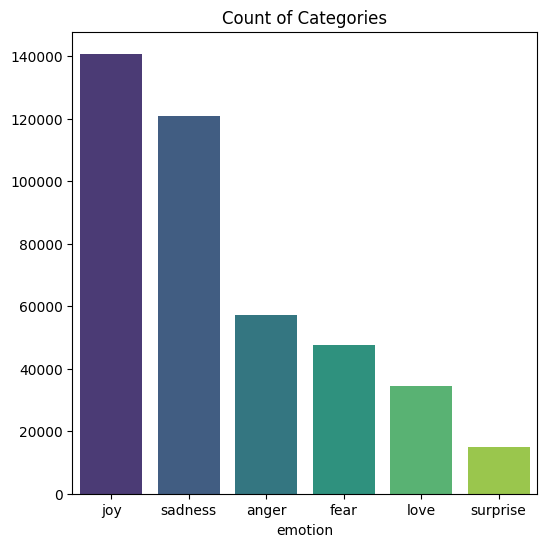

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt

# emotion category 시각화
count = data['emotion'].value_counts()

fig, axs = plt.subplots(figsize = (6, 6), facecolor='white')
palette = sns.color_palette("viridis")
sns.set_palette(palette)

sns.barplot(x=count.index, y=count.values, ax=axs, palette="viridis")
axs.set_title('Count of Categories')

In [14]:
dataset = Dataset.from_pandas(data)

# 데이터셋을 훈련 및 테스트 데이터셋으로 분할
# test_size=0.2: 전체 데이터의 20%를 테스트 데이터로 할당하고, 나머지 80%를 훈련 데이터로 할당
dataset = dataset.train_test_split(test_size=0.2)

# 훈련 데이터와 테스트 데이터를 각각 추출
train_data = dataset["train"]  # 80% 훈련 데이터
test_data = dataset["test"]    # 20% 테스트 데이터

In [15]:
train_data

Dataset({
    features: ['text', 'label', 'emotion'],
    num_rows: 332898
})

In [16]:
test_data

Dataset({
    features: ['text', 'label', 'emotion'],
    num_rows: 83225
})

# Tokenization and Quantization

## Loading the Tokenizer

In [17]:
model_id = "google/gemma-2-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

## (OPTION) reduce the dataset

In [37]:
train_sampled = train_data.train_test_split(train_size=0.01, seed=42)['train']
test_sampled = test_data.train_test_split(train_size=0.01, seed=42)['train']

print(f"Train Sampled Rows: {len(train_sampled)}")
print(f"Test Sampled Rows: {len(test_sampled)}")

Train Sampled Rows: 3328
Test Sampled Rows: 832


## Text Tokenization

In [38]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [39]:
tokenized_train = train_sampled.map(preprocess_function, batched=True)
tokenized_test = test_sampled.map(preprocess_function, batched=True)

Map:   0%|          | 0/3328 [00:00<?, ? examples/s]

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

In [40]:
tokenized_test[:1]

{'text': ['i kind of feel like doing something rebellious and out of character to shock you people instead of things i ll go with nine'],
 'label': [3],
 'emotion': ['anger'],
 'input_ids': [[2,
   235252,
   2858,
   576,
   2375,
   1154,
   3900,
   2775,
   122998,
   578,
   921,
   576,
   3285,
   577,
   15733,
   692,
   1461,
   5918,
   576,
   2652,
   496,
   10547,
   871,
   675,
   9981]],
 'attention_mask': [[1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1]]}

## Data Collator

In [22]:
id2label = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
label2id = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

In [23]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Defining Evaluation Metrics

In [46]:
import evaluate
import numpy as np

metric_accuracy = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")
metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)  # Convert probabilities to predicted labels
    # Compute the metrics
    accuracy = metric_accuracy.compute(predictions=predictions, references=labels)  # Accuracy does not need 'average'
    f1 = metric_f1.compute(predictions=predictions, references=labels, average='weighted')  # Use 'average' for F1
    precision = metric_precision.compute(predictions=predictions, references=labels, average='weighted')  # Use 'average'
    recall = metric_recall.compute(predictions=predictions, references=labels, average='weighted')  # Use 'average'

    return {
        "accuracy": accuracy["accuracy"],  # Extract accuracy from dict
        "f1": f1["f1"],  # Extract f1 from dict
        "precision": precision["precision"],  # Extract precision from dict
        "recall": recall["recall"]  # Extract recall from dict
    }

## Quantization Configuration

In [5]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Enables 4-bit quantization
    bnb_4bit_use_double_quant=True,  # Use double quantization for potentially higher accuracy (optional)
    bnb_4bit_quant_type="nf4",  # Quantization type (specifics depend on hardware and library)
    bnb_4bit_compute_dtype=torch.bfloat16  # Compute dtype for improved efficiency (optional)
)

NameError: name 'BitsAndBytesConfig' is not defined

# Loading GEMMA-2b-it in 4-bit

In [26]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_id,  # "google/gemma-2b-it"
    num_labels=6,
    id2label=id2label,
    label2id=label2id,
    quantization_config=bnb_config,  # configuration for quantization
    device_map={"": 0}  # Optional dictionary specifying device mapping (single GPU with index 0 here)
)

# Note: load_in_4bit argument is deprecated, use quantization_config instead

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at google/gemma-2-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Gradient Checkpointing
model.gradient_checkpointing_enable()

In [28]:
# Model Preparation
from peft import prepare_model_for_kbit_training

model = prepare_model_for_kbit_training(model)

## Identifying LoRa Modules

In [29]:
import bitsandbytes as bnb

def find_linear_names(model):
    """
    This function identifies all linear layer names within a model that use 4-bit quantization.
    Args:
        model (torch.nn.Module): The PyTorch model to inspect.
    Returns:
        list: A list containing the names of all identified linear layers with 4-bit quantization.
    """
    cls = bnb.nn.Linear4bit

    # Set to store identified layer names
    lora_module_names = set()

    # Iterate through named modules in the model
    for name, module in model.named_modules():
        # Check if the current module is an instance of the 4-bit linear layer class
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

        # Special case: remove 'lm_head' if present
        if 'lm_head' in lora_module_names:
            lora_module_names.remove('lm_head')
    return list(lora_module_names)

# Example usage:
modules = find_linear_names(model)
print(modules)
# ['up_proj', 'v_proj', 'q_proj', 'down_proj', 'o_proj', 'gate_proj', 'k_proj']

['v_proj', 'k_proj', 'down_proj', 'o_proj', 'q_proj', 'gate_proj', 'up_proj']


## LoRA Config

In [30]:
from peft import get_peft_model, LoraConfig

lora_config = LoraConfig(
    r=64,  # Reduction factor (lower r means more parameters in the adapter)
    lora_alpha=32,  # Dimensionality of the adapter projection
    target_modules=modules,  # List of modules to apply the LoRA adapter
    lora_dropout=0.05,  # Dropout rate for the adapter
    bias="none",  # Bias configuration for the adapter
    task_type="SEQ_CLS"  # Task type (sequence classification in this case)
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

#trainable params: 83,080,704 || all params: 2,697,436,416 || trainable%: 3.0800

trainable params: 83,080,704 || all params: 2,697,436,416 || trainable%: 3.0800


# Training with LoRA Adapter

## Training Arguments

In [31]:
from transformers import (
    AutoModelForTokenClassification,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback,
    EarlyStoppingCallback)

In [48]:
training_args = TrainingArguments(
    output_dir="Quiett/PaperPrism_gemma2",  # Output directory for checkpoints
    learning_rate=2e-5,  # Learning rate for the optimizer
    per_device_train_batch_size=1,  # Batch size per device
    per_device_eval_batch_size=1,  # Batch size per device for evaluation
    num_train_epochs=1,  # Number of training epochs
    weight_decay=0.01,  # Weight decay for regularization
    evaluation_strategy="steps",  # Evaluate after each epoch
    save_strategy="steps",  # Save model checkpoints after each epoch
    load_best_model_at_end=True,  # Load the best model based on the chosen metric
    push_to_hub=True,  # Disable pushing the model to the Hugging Face Hub
    report_to="none",  # Disable logging to Weight&Bias
    metric_for_best_model='eval_loss',
    eval_steps=100,
    optim="paged_adamw_8bit")  # Metric for selecting the best model

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [49]:
#using early stop
early_stop = EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=.0)

In [34]:
print(model)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): Gemma2ForSequenceClassification(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2304, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDic

In [50]:
trainer = Trainer(
    model=model,  # The LoRA-adapted model
    args=training_args,  # Training arguments
    train_dataset=tokenized_train,  # Training dataset
    eval_dataset=tokenized_test,  # Evaluation dataset
    tokenizer=tokenizer,  # Tokenizer for processing text
    data_collator=data_collator,  # Data collator for preparing batches
    compute_metrics=compute_metrics,  # Function to calculate evaluation metrics
    callbacks=[early_stop]  # Optional early stopping callback
)

trainer.train()

<ipython-input-50-3789e0e13831>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,No log,1.594223,0.724760,0.706069,0.708106,0.724760
200,No log,1.600468,0.752404,0.724147,0.748569,0.752404
300,No log,1.453146,0.765625,0.750622,0.755487,0.765625
400,No log,1.815660,0.733173,0.713406,0.748394,0.733173
500,0.591000,1.456225,0.782452,0.775340,0.777383,0.782452
600,0.591000,1.378584,0.769231,0.763640,0.781613,0.769231
700,0.591000,2.205487,0.747596,0.714206,0.784529,0.747596


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an except

TrainOutput(global_step=700, training_loss=0.8046310424804688, metrics={'train_runtime': 1756.2208, 'train_samples_per_second': 1.895, 'train_steps_per_second': 1.895, 'total_flos': 178202844997632.0, 'train_loss': 0.8046310424804688, 'epoch': 0.21033653846153846})

In [54]:
trainer.push_to_hub("Quiett/PaperPrism_gemma2")

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Quiett/PaperPrism_gemma2/commit/0c41135706c068be2d0c87e1c608862846a129cf', commit_message='Quiett/PaperPrism_gemma2', commit_description='', oid='0c41135706c068be2d0c87e1c608862846a129cf', pr_url=None, pr_revision=None, pr_num=None)

# Load Model

In [1]:
id2label = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
label2id = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model from the Hugging Face Hub
model = AutoModelForSequenceClassification.from_pretrained(
    "Quiett/PaperPrism_gemma2",
    num_labels=6,
    id2label=id2label,
    label2id=label2id,
    device_map={"": 0}  # Optional dictionary specifying device mapping (single GPU with index 0 here)
)

# Load the tokenizer (if available)
tokenizer = AutoTokenizer.from_pretrained("Quiett/PaperPrism_gemma2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at google/gemma-2-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
text = "This was a masterpiece. wow"
inputs = tokenizer(text, return_tensors="pt")

In [6]:
import torch
import torch.nn.functional as F

# Perform inference
with torch.no_grad():
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    outputs = model(**inputs)
    logits = outputs.logits

# Convert logits to probabilities
probabilities = F.softmax(logits, dim=-1)

# Get the predicted emotion and its score
predicted_emotion_idx = torch.argmax(probabilities, dim=-1).item()
predicted_emotion = model.config.id2label[predicted_emotion_idx]
predicted_score = probabilities[0, predicted_emotion_idx].item()

# Return the result
result = {
    "emotion": predicted_emotion,
    "score": predicted_score
}

print(result)

{'emotion': 'joy', 'score': 0.9190474152565002}


# Input Dataset

## (example)Dataset(huggingface)

In [ ]:
from datasets import load_dataset

# or load the separate splits if the dataset has train/validation/test splits
test_txt = load_dataset("manu/project_gutenberg", split="en")

README.md:   0%|          | 0.00/2.94k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

(…)-00000-of-00003-f8e581c008ccc7f2.parquet:   0%|          | 0.00/142M [00:00<?, ?B/s]

(…)-00001-of-00003-44c9c3b458e2eef3.parquet:   0%|          | 0.00/135M [00:00<?, ?B/s]

(…)-00002-of-00003-084edb3f286e612c.parquet:   0%|          | 0.00/148M [00:00<?, ?B/s]

(…)-00000-of-00052-7cda8f63c262acf8.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

(…)-00001-of-00052-5c2b3fd5e60f0124.parquet:   0%|          | 0.00/209M [00:00<?, ?B/s]

(…)-00002-of-00052-835bd07d97f52cbd.parquet:   0%|          | 0.00/215M [00:00<?, ?B/s]

(…)-00003-of-00052-3827386b583e4d76.parquet:   0%|          | 0.00/239M [00:00<?, ?B/s]

(…)-00004-of-00052-a2f24c4fe858fe0f.parquet:   0%|          | 0.00/268M [00:00<?, ?B/s]

(…)-00005-of-00052-2a13fc98474cabed.parquet:   0%|          | 0.00/277M [00:00<?, ?B/s]

(…)-00006-of-00052-81d2618caede0093.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

(…)-00007-of-00052-de0de442f370b789.parquet:   0%|          | 0.00/217M [00:00<?, ?B/s]

(…)-00008-of-00052-a83055e8ef415c07.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00009-of-00052-f2f126633fa25668.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

(…)-00010-of-00052-2226b3722aa696eb.parquet:   0%|          | 0.00/276M [00:00<?, ?B/s]

(…)-00011-of-00052-6c9ae05ed451701f.parquet:   0%|          | 0.00/319M [00:00<?, ?B/s]

(…)-00012-of-00052-2de5b14941be3266.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

(…)-00013-of-00052-a66a5e317603bb21.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

(…)-00014-of-00052-e976ff9fa7c0a4c2.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

(…)-00015-of-00052-9a9fd49be8a70a6c.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

(…)-00016-of-00052-5006e8c00e35ad72.parquet:   0%|          | 0.00/278M [00:00<?, ?B/s]

(…)-00017-of-00052-c37121d3035604a6.parquet:   0%|          | 0.00/196M [00:00<?, ?B/s]

(…)-00018-of-00052-76fc57ebfaac39a2.parquet:   0%|          | 0.00/216M [00:00<?, ?B/s]

(…)-00019-of-00052-05068b06d8a4ffb7.parquet:   0%|          | 0.00/235M [00:00<?, ?B/s]

(…)-00020-of-00052-31ef1cece5305678.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00021-of-00052-82812d42cefe9a5b.parquet:   0%|          | 0.00/279M [00:00<?, ?B/s]

(…)-00022-of-00052-061a44c5aeff4f98.parquet:   0%|          | 0.00/297M [00:00<?, ?B/s]

(…)-00023-of-00052-380917a82781d4aa.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

(…)-00024-of-00052-fb2f9a960ee8c75e.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

(…)-00025-of-00052-9c00570871767dea.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

(…)-00026-of-00052-8719637a331ec653.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00027-of-00052-9d8bfd7843e9718f.parquet:   0%|          | 0.00/277M [00:00<?, ?B/s]

(…)-00028-of-00052-2e237a8d8b810dec.parquet:   0%|          | 0.00/209M [00:00<?, ?B/s]

(…)-00029-of-00052-780d5f400fd85afa.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

(…)-00030-of-00052-cfdc6f381f17e852.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

(…)-00031-of-00052-e7f5d815a26b08d0.parquet:   0%|          | 0.00/232M [00:00<?, ?B/s]

(…)-00032-of-00052-4ed9cbf89e3d13b5.parquet:   0%|          | 0.00/263M [00:00<?, ?B/s]

(…)-00033-of-00052-4c525b2c5bfc7b3f.parquet:   0%|          | 0.00/277M [00:00<?, ?B/s]

(…)-00034-of-00052-0f04bcad9d91ea41.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

(…)-00035-of-00052-617bd55ce8eaaf8c.parquet:   0%|          | 0.00/207M [00:00<?, ?B/s]

(…)-00036-of-00052-dea698a178ee5475.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

(…)-00037-of-00052-80239e718491affb.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00038-of-00052-671117f0cc621546.parquet:   0%|          | 0.00/275M [00:00<?, ?B/s]

(…)-00039-of-00052-f766a27e24b911d6.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

(…)-00040-of-00052-5f304ed689a13135.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

(…)-00041-of-00052-6f04cd012627fa08.parquet:   0%|          | 0.00/210M [00:00<?, ?B/s]

(…)-00042-of-00052-94e90b865e11f015.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

(…)-00043-of-00052-545c5249d7f68142.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

(…)-00044-of-00052-2f8a81e4b2cb26bd.parquet:   0%|          | 0.00/270M [00:00<?, ?B/s]

(…)-00045-of-00052-bbb08eac7b16b553.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

(…)-00046-of-00052-fbf5b6f877101255.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

(…)-00047-of-00052-b53a9aba6fd08df1.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

(…)-00048-of-00052-c3e4665ddb21ff40.parquet:   0%|          | 0.00/238M [00:00<?, ?B/s]

(…)-00049-of-00052-238a44ba6d899475.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

(…)-00050-of-00052-119c77546b4d5bc3.parquet:   0%|          | 0.00/294M [00:00<?, ?B/s]

(…)-00051-of-00052-416e3a1d8d8e7d86.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

(…)-00000-of-00001-ad684e007393cf76.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

(…)-00000-of-00005-a475c3836a0ce5b5.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

(…)-00001-of-00005-b6213362f858795a.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

(…)-00002-of-00005-cf81716abdc38e6a.parquet:   0%|          | 0.00/202M [00:00<?, ?B/s]

(…)-00003-of-00005-32d4f9159674f920.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

(…)-00004-of-00005-6c2bd994bbdaed75.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

(…)-00000-of-00001-62485f87cf89f498.parquet:   0%|          | 0.00/123M [00:00<?, ?B/s]

(…)-00000-of-00002-ec9215c2bba222c1.parquet:   0%|          | 0.00/85.5M [00:00<?, ?B/s]

(…)-00001-of-00002-a8989d8ed3a39aaf.parquet:   0%|          | 0.00/123M [00:00<?, ?B/s]

(…)-00000-of-00001-68933bed4abc7dfd.parquet:   0%|          | 0.00/2.45M [00:00<?, ?B/s]

(…)-00000-of-00001-f6940f76b5585b13.parquet:   0%|          | 0.00/73.9M [00:00<?, ?B/s]

(…)-00000-of-00001-c0a99d21d8849748.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

(…)-00000-of-00001-6d07271c1c00324d.parquet:   0%|          | 0.00/40.5M [00:00<?, ?B/s]

(…)-00000-of-00001-bca42330c6f1826c.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

Generating de split:   0%|          | 0/3131 [00:00<?, ? examples/s]

Generating en split:   0%|          | 0/61340 [00:00<?, ? examples/s]

Generating es split:   0%|          | 0/1202 [00:00<?, ? examples/s]

Generating fr split:   0%|          | 0/5493 [00:00<?, ? examples/s]

Generating it split:   0%|          | 0/1008 [00:00<?, ? examples/s]

Generating nl split:   0%|          | 0/1420 [00:00<?, ? examples/s]

Generating pl split:   0%|          | 0/34 [00:00<?, ? examples/s]

Generating pt split:   0%|          | 0/1111 [00:00<?, ? examples/s]

Generating ru split:   0%|          | 0/6 [00:00<?, ? examples/s]

Generating sv split:   0%|          | 0/388 [00:00<?, ? examples/s]

Generating zh split:   0%|          | 0/437 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/38 [00:00<?, ?it/s]

In [ ]:
test_txt

Dataset({
    features: ['id', 'text'],
    num_rows: 61340
})

In [ ]:
test_txt[0]['text']

'The Project Gutenberg eBook, Addison, by William John Courthope\n\n\nThis eBook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  You may copy it, give it away or\nre-use it under the terms of the Project Gutenberg License included\nwith this eBook or online at www.gutenberg.org\n\n\n\n\n\nTitle: Addison\n\n\nAuthor: William John Courthope\n\n\n\nRelease Date: November 27, 2012  [eBook #41496]\n\nLanguage: English\n\nCharacter set encoding: ISO-8859-1\n\n\n***START OF THE PROJECT GUTENBERG EBOOK ADDISON***\n\n\nE-text prepared by the Online Distributed Proofreading Team\n(http://www.pgdp.net) from page images generously made available by\nInternet Archive (http://archive.org)\n\n\n\nNote: Images of the original pages are available through\n      Internet Archive. See\n      http://archive.org/details/addison_00cour\n\n\nTranscriber\'s note:\n\n      Text enclosed by underscores is in italics (_italics_).\n\n      Text enclosed by curly brackets

## Load pdf(using PyMuPDF)

In [7]:
pip install datasets PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 56.3 MB/s eta 0:00:00


In [18]:
from datasets import Dataset
import fitz  # PyMuPDF

# Step 1: Function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    text = ""
    with fitz.open(pdf_path) as doc:
        for page in doc:
            text += page.get_text()
    return text

# Step 2: Specify the PDF path
pdf_path = "/content/The Project Gutenberg eBook of Moby Dick; Or the Whale, by Herman Melville.pdf"  # Change this to your PDF file path

# Step 3: Extract text from the PDF
pdf_text = extract_text_from_pdf(pdf_path)

# Step 4: Create a new dataset from the extracted text
# Here, we create a new dictionary with the extracted text
new_data = {
    'text': [pdf_text],  # Wrap the text in a list to match dataset format
}

# Step 5: Convert the dictionary into a Hugging Face dataset
pdf_dataset = Dataset.from_dict(new_data)

# Step 6: Optionally, save the dataset to a file
pdf_dataset.save_to_disk('pdf_dataset')

# Print out the first few entries of the dataset
print(pdf_dataset[:5])


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

{'text': ['around them, has a totally different air from those engaged in\nregular voyage.” —Currents and Whaling. U.S. Ex. Ex.\n“Pedestrians in the vicinity of London and elsewhere may recollect\nhaving seen large curved bones set upright in the earth, either to\nform arches over gateways, or entrances to alcoves, and they may\nperhaps have been told that these were the ribs of whales.” —Tales\nof a Whale Voyager to the Arctic Ocean.\n“It was not till the boats returned from the pursuit of these\nwhales, that the whites saw their ship in bloody possession of the\nsavages enrolled among the crew.” —Newspaper Account of the\nTaking and Retaking of the Whale-Ship Hobomack.\n“It is generally well known that out of the crews of Whaling\nvessels (American) few ever return in the ships on board of which\nthey departed.” —Cruise in a Whale Boat.\n“Suddenly a mighty mass emerged from the water, and shot up\nperpendicularly into the air. It was the whale.” —Miriam Coffin or the\nWhale Fisherman

In [ ]:
# def processed_paragraphs(text):
#     """
#     주어진 텍스트를 단락(문단) 단위로 분리하고 각 단락을 처리하는 함수

#     Args:
#         text: 분석할 텍스트

#     Returns:
#         list: 각 단락의 텍스트를 리스트로 반환
#     """
#     # Split the text into paragraphs based on double newlines
#     paragraphs = text.split('\n\n')

#     # Clean up leading/trailing whitespace and remove any empty paragraphs
#     processed_paragraphs = [paragraph.strip() for paragraph in paragraphs if paragraph.strip()]

#     return processed_paragraphs

In [19]:
def extract_chapters(text):
    """
    주어진 텍스트를 CHAPTER 단위로 분리하여 리스트에 저장하는 함수

    Args:
        text: 분석할 텍스트

    Returns:
        list: 각 CHAPTER에 해당하는 문장들의 리스트
    """
    chapters = []
    current_chapter = []
    for line in text.splitlines():
      if line.startswith("CHAPTER") and "." in line:
        if current_chapter: #current_chapter가 비어있지 않은 경우 조건문 실행
          chapters.append(current_chapter)
          current_chapter = []
      else:
        current_chapter.append(line)

    if current_chapter:
      chapters.append(current_chapter)

    return chapters

In [20]:
def extract_chapters(text):
    """
    주어진 텍스트를 CHAPTER 단위로 분리하여 리스트에 저장하는 함수

    Args:
        text: 분석할 텍스트

    Returns:
        list: 각 CHAPTER에 해당하는 문장들의 리스트
    """
    import re

    # Regular expression to match "CHAPTER" or "."
    chapter_split_regex = r'(CHAPTER \d+\.|\.)'

    # Splitting the text while keeping the delimiter
    parts = re.split(chapter_split_regex, text)

    # Initialize chapters list
    chapters = []

    # Combine the split parts into chapters
    current_chapter = ""
    for part in parts:
        # Strip whitespace and remove newlines
        part = part.strip().replace('\n', ' ')
        if part:
            current_chapter += part + " "
            if part.endswith(".") or "CHAPTER" in part:
                # When we reach a chapter or a period, finalize the chapter
                current_chapter = current_chapter.strip()
                # Add to chapters only if length is 15 or more
                if len(current_chapter) >= 30:
                    chapters.append(current_chapter)
                current_chapter = ""

    # If there's any remaining text in current_chapter, check its length before adding
    if current_chapter and len(current_chapter) >= 30:
        chapters.append(current_chapter.strip())

    return chapters

In [21]:
pdf_dataset

Dataset({
    features: ['text'],
    num_rows: 1
})

In [22]:
example = pdf_dataset[0]['text']
result = extract_chapters(example)

In [ ]:
# result

# 출력 저장

In [27]:
import torch
import torch.nn.functional as F

def classify_emotion(text):
    # Tokenize the input text
    encoding = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    encoding = {key: value.to(model.device) for key, value in encoding.items()}  # Send inputs to the same device as the model

    # Perform inference using the model (no gradient calculation)
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits  # Raw prediction scores

    # Convert logits to probabilities using softmax
    probabilities = F.softmax(logits, dim=-1)

    # Get the predicted emotion index (highest probability)
    predicted_emotion_idx = torch.argmax(probabilities, dim=-1).item()

    # Use id2label mapping to get the emotion label
    id2label = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
    predicted_emotion = id2label[predicted_emotion_idx]

    # Get the probability (score) of the predicted emotion
    predicted_score = probabilities[0, predicted_emotion_idx].item()

    # Return the result as a dictionary, including the original text
    result = {
        "emotion": predicted_emotion,
        "score": predicted_score,
        "text": text  # Include the original text in the result
    }

    return result

In [28]:
def classify_emotions_in_chunks(chunks):
    results = []  # To store the classification results
    for chunk in chunks:
        if chunk.strip():  # Ensure that the chunk is not empty
            classified_result = classify_emotion(chunk)
            results.append({
                'label': classified_result['emotion'],
                'accuracy': classified_result['score'],
                'text': classified_result['text']  # Use the text from the classified result
            })
    return results

In [32]:
result[0:3]

['around them, has a totally different air from those engaged in regular voyage .',
 '“Pedestrians in the vicinity of London and elsewhere may recollect having seen large curved bones set upright in the earth, either to form arches over gateways, or entrances to alcoves, and they may perhaps have been told that these were the ribs of whales .',
 '” —Tales of a Whale Voyager to the Arctic Ocean .']

In [33]:
emotion_results = classify_emotions_in_chunks(result[0:3])

In [34]:
len(emotion_results)

3

In [36]:
# Function to filter classification output by threshold

def sentiment_threshold(output, threshold=0.7):
    threshold_data = []  # To store the filtered results
    for result in output:  # Iterate through the results
        if result['accuracy'] >= threshold:  # Check if score is above the threshold
            threshold_data.append({'label': result['label'], 'accuracy': result['accuracy'], 'text': result['text']})
    return threshold_data

In [37]:
a = sentiment_threshold(emotion_results)
print(a)

[{'label': 'joy', 'accuracy': 0.999441921710968, 'text': 'around them, has a totally different air from those engaged in regular voyage .'}, {'label': 'joy', 'accuracy': 0.7530627846717834, 'text': '“Pedestrians in the vicinity of London and elsewhere may recollect having seen large curved bones set upright in the earth, either to form arches over gateways, or entrances to alcoves, and they may perhaps have been told that these were the ribs of whales .'}]


In [38]:
def process_list(input):
  results = classify_emotions_in_chunks(input)
  st = sentiment_threshold(results)
  sentiment_classifications = []
  if st:
    sentiment_classifications.extend(st)
  return sentiment_classifications

In [39]:
moby_dick = process_list(result)

In [41]:
moby_dick[:11]

[{'label': 'joy',
  'accuracy': 0.999240517616272,
  'text': 'around them, has a totally different air from those engaged in regular voyage .'},
 {'label': 'joy',
  'accuracy': 0.7636242508888245,
  'text': '“Pedestrians in the vicinity of London and elsewhere may recollect having seen large curved bones set upright in the earth, either to form arches over gateways, or entrances to alcoves, and they may perhaps have been told that these were the ribs of whales .'},
 {'label': 'joy',
  'accuracy': 0.7121750712394714,
  'text': '” —Tales of a Whale Voyager to the Arctic Ocean .'},
 {'label': 'joy',
  'accuracy': 0.9857965111732483,
  'text': '“It is generally well known that out of the crews of Whaling vessels (American) few ever return in the ships on board of which they departed .'},
 {'label': 'joy',
  'accuracy': 0.9185789227485657,
  'text': '“Suddenly a mighty mass emerged from the water, and shot up perpendicularly into the air .'},
 {'label': 'joy',
  'accuracy': 0.90633654594421

## example test

In [16]:
# input_list = [
#     "This was a masterpiece. Wow!",
#     "I feel really sad today.",
#     "This movie was okay, nothing special.",
#     "I'm so excited about this new project!"
# ]

# # Process the list
# processed_results = process_list(input_list)

# print(processed_results)

[{'label': 'joy', 'accuracy': 0.9418635368347168}, {'label': 'sadness', 'accuracy': 0.999991774559021}, {'label': 'joy', 'accuracy': 0.805534303188324}, {'label': 'joy', 'accuracy': 0.9999370574951172}]


In [23]:
# example_1 = process_list(result[1])

In [26]:
# result[1]

'“Pedestrians in the vicinity of London and elsewhere may recollect having seen large curved bones set upright in the earth, either to form arches over gateways, or entrances to alcoves, and they may perhaps have been told that these were the ribs of whales .'

In [24]:
# example_1

[{'label': 'love', 'accuracy': 0.965182900428772},
 {'label': 'joy', 'accuracy': 0.7159148454666138},
 {'label': 'joy', 'accuracy': 0.7594776749610901},
 {'label': 'joy', 'accuracy': 0.8123348951339722},
 {'label': 'joy', 'accuracy': 0.7366414666175842},
 {'label': 'joy', 'accuracy': 0.8010727763175964},
 {'label': 'joy', 'accuracy': 0.7124902606010437},
 {'label': 'joy', 'accuracy': 0.7088725566864014},
 {'label': 'joy', 'accuracy': 0.735232412815094},
 {'label': 'joy', 'accuracy': 0.7051975131034851},
 {'label': 'joy', 'accuracy': 0.817081093788147},
 {'label': 'joy', 'accuracy': 0.7111508250236511},
 {'label': 'joy', 'accuracy': 0.7109060287475586},
 {'label': 'joy', 'accuracy': 0.7035432457923889},
 {'label': 'joy', 'accuracy': 0.7050939798355103},
 {'label': 'joy', 'accuracy': 0.745409369468689},
 {'label': 'joy', 'accuracy': 0.8076839447021484},
 {'label': 'joy', 'accuracy': 0.7243987321853638},
 {'label': 'joy', 'accuracy': 0.7011255621910095},
 {'label': 'joy', 'accuracy': 0.74

## save to json

In [43]:
import json

moby_dick_json = json.dumps(moby_dick)

In [44]:
with open('moby_dick_json', 'w') as f:
  json.dump(moby_dick_json, f)